<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
!pip install yfinance

In [152]:
!pip install pmdarima statsmodels scikit-learn

In [153]:
#!pip install --upgrade scikit-learn pmdarima

In [154]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Load Data

In [155]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('ME').last()


[*********************100%***********************]  1 of 1 completed


In [156]:
df

Ticker,y
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2024-11-30,96449.054688
2024-12-31,93429.203125
2025-01-31,102405.023438


<Axes: xlabel='Date'>

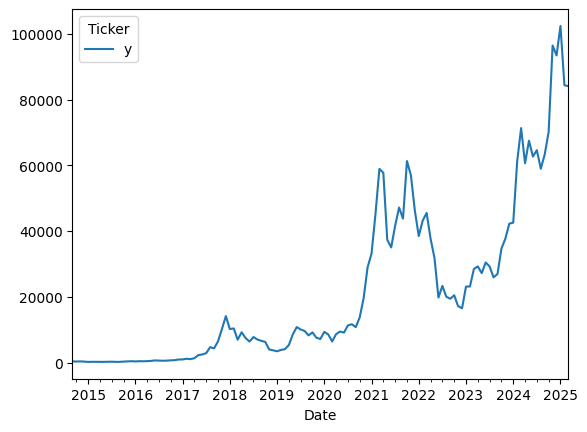

In [157]:
df.plot()

## Train / Test

In [158]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)

(88, 1)
(39, 1)


In [159]:
train

Ticker,y
Date,
2014-09-30,386.944000
2014-10-31,338.321014
2014-11-30,378.046997
2014-12-31,320.192993
2015-01-31,217.464005
...,...
2021-08-31,47166.687500
2021-09-30,43790.894531
2021-10-31,61318.957031


# Analysis

<Axes: xlabel='Date'>

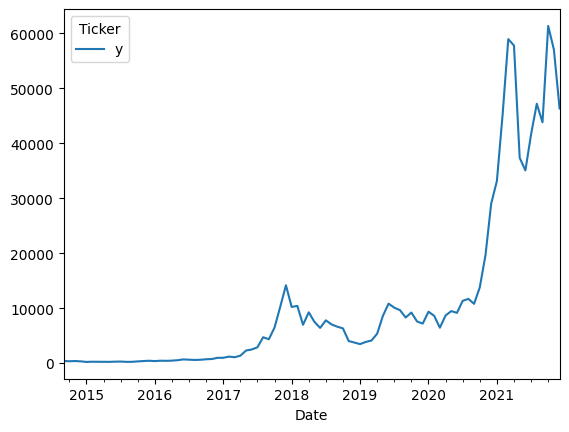

In [160]:
train.plot()

<Axes: xlabel='Date'>

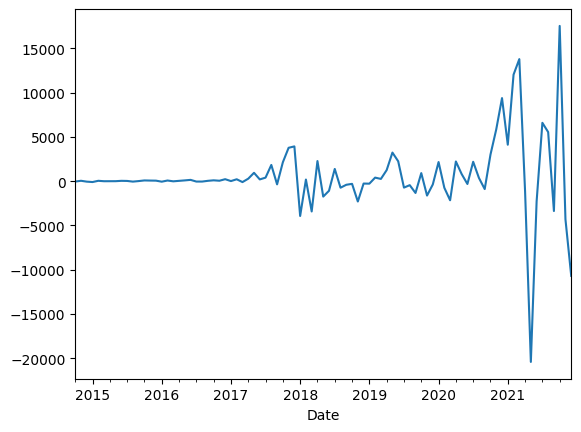

In [161]:
diff1 = train['y'].diff(1).dropna()
diff1.plot()

## Normalization

In [162]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [163]:
train_log

Ticker,y
Date,
2014-09-30,5.958280
2014-10-31,5.823995
2014-11-30,5.935019
2014-12-31,5.768924
2015-01-31,5.382033
...,...
2021-08-31,10.761443
2021-09-30,10.687181
2021-10-31,11.023844


<Axes: xlabel='Date'>

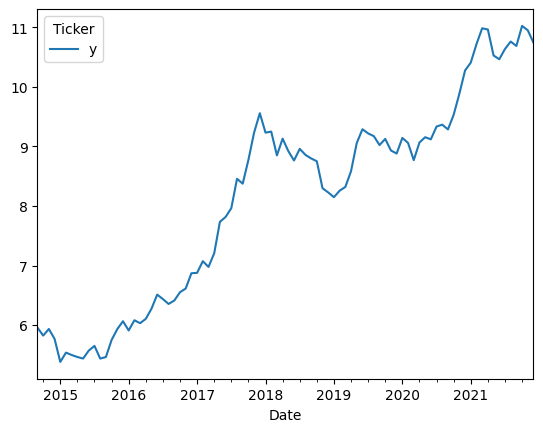

In [164]:
train_log.plot()

## Differentiation

In [165]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Série Original

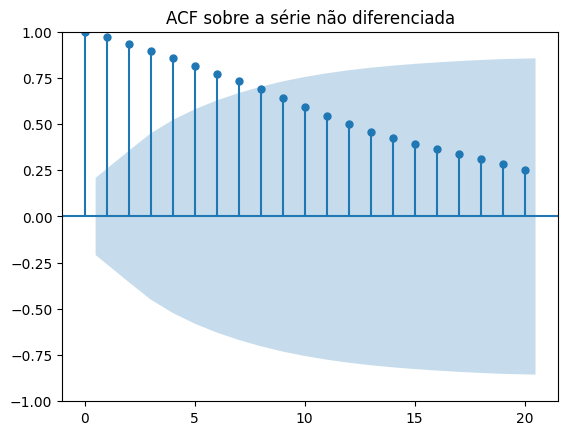

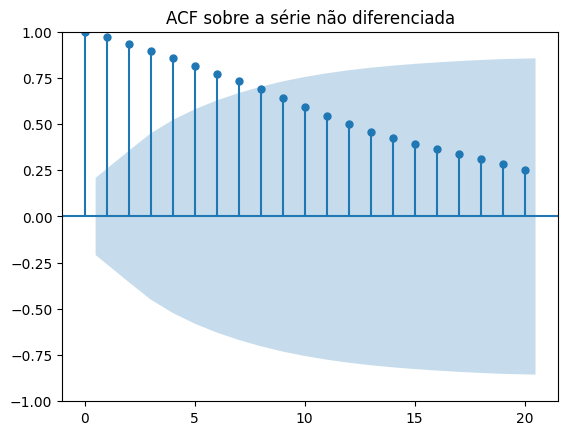

In [166]:
plot_acf(train_log, title='ACF sobre a série não diferenciada')

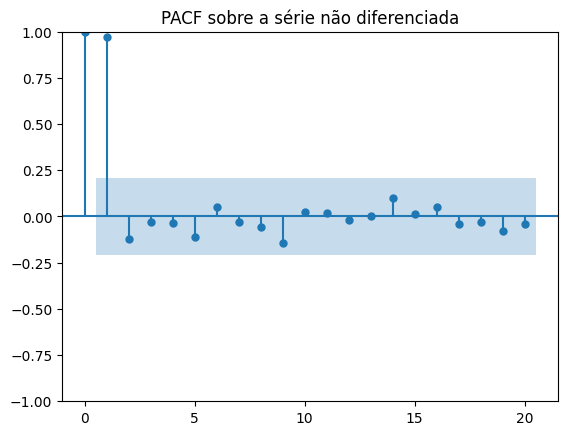

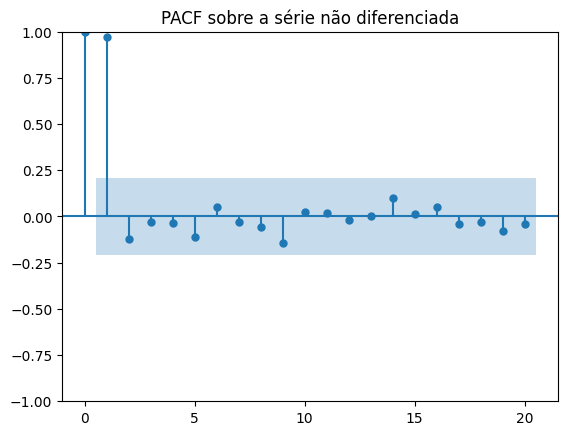

In [167]:
plot_pacf(train_log, title='PACF sobre a série não diferenciada')

### 1ª diff

In [168]:
diff1 = train_log['y'].diff(1).dropna()

<Axes: xlabel='Date'>

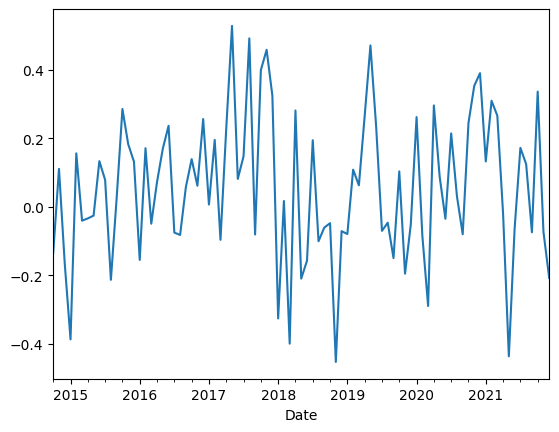

In [169]:
diff1.plot()

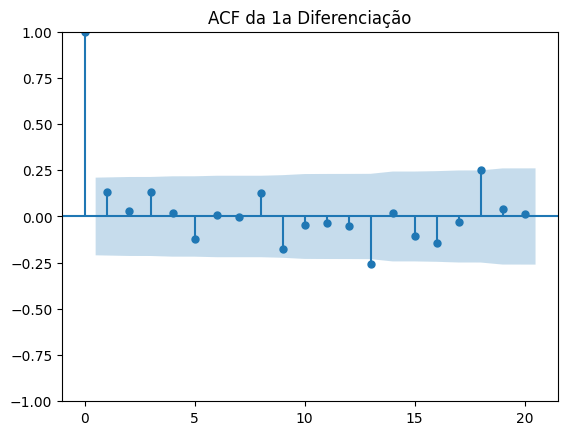

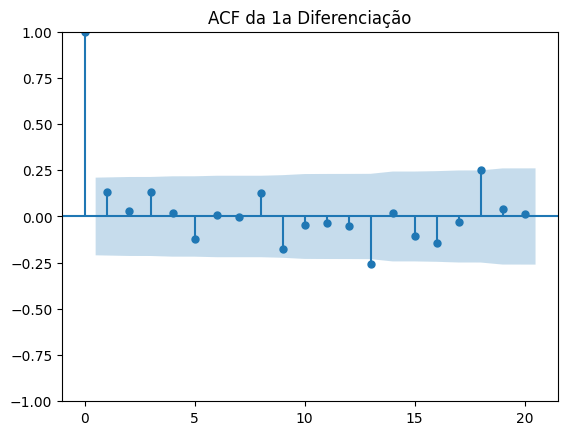

In [170]:
plot_acf(diff1, title='ACF da 1a Diferenciação')

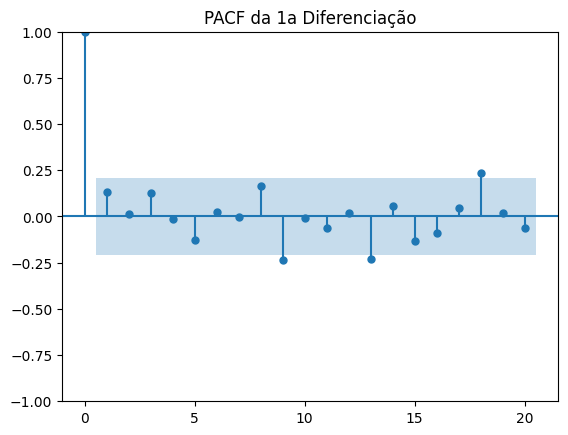

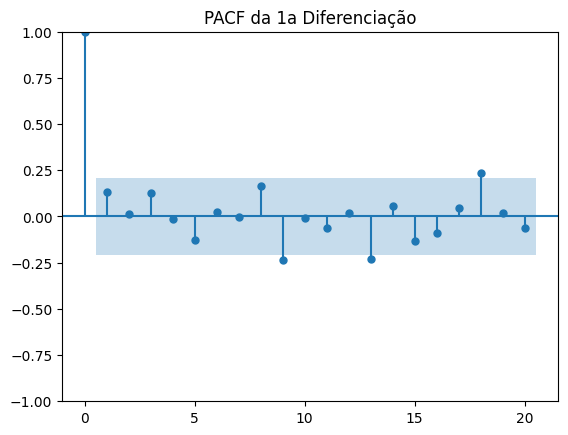

In [171]:
plot_pacf(diff1, title='PACF da 1a Diferenciação')

In [172]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.984818e+00
p-value                 2.565747e-12
# lags used             0.000000e+00
# observations          8.600000e+01
critical value (1%)    -3.508783e+00
critical value (5%)    -2.895784e+00
critical value (10%)   -2.585038e+00
Reject the null hypothesis
Data has no unit root and is stationary


### 2ª diff

In [173]:
diff2 = diff1.diff(1).dropna()


<Axes: xlabel='Date'>

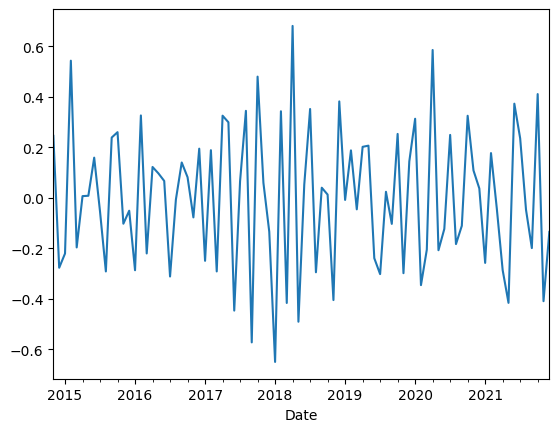

In [174]:
diff2.plot()

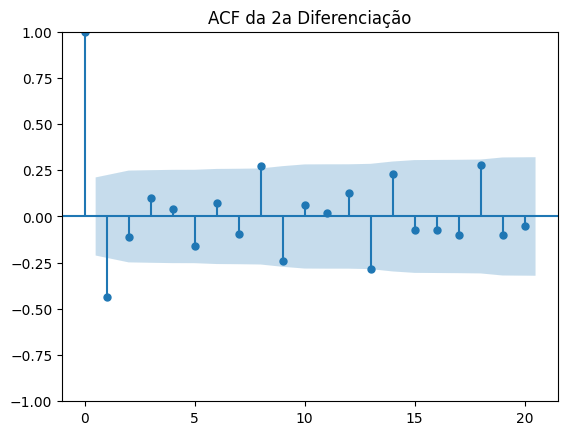

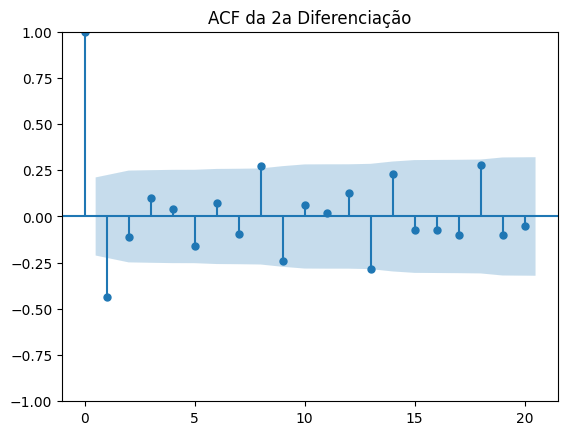

In [175]:
plot_acf(diff2, title='ACF da 2a Diferenciação')

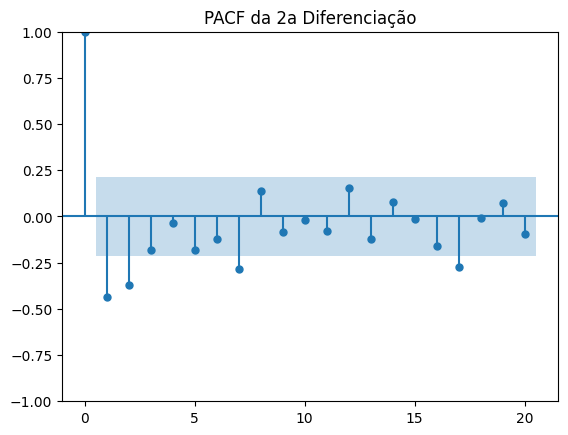

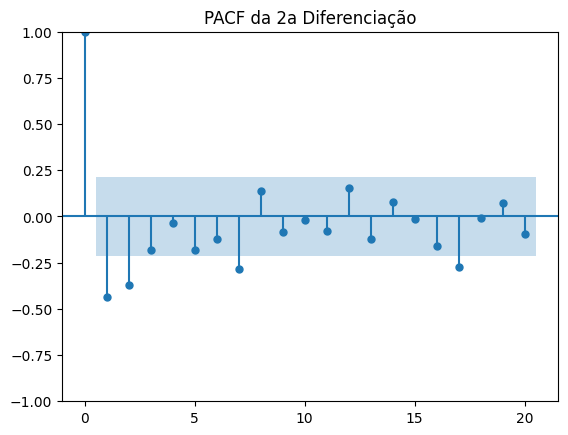

In [176]:
plot_pacf(diff2, title='PACF da 2a Diferenciação')

In [177]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.253426e+00
p-value                 4.397345e-08
# lags used             6.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
Reject the null hypothesis
Data has no unit root and is stationary


## Conclusion
Tomando como base o procedimento definido em https://otexts.com/fpp3/arima-r.html, a análise dos gráficos sugere os seguintes hiperparâmetros:

In [178]:
p = 1
d = 0
q = 0

# Modelo AR

In [179]:
mod1 = AutoReg(train_log['y'], p, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   88
Model:                     AutoReg(1)   Log Likelihood                  11.389
Method:               Conditional MLE   S.D. of innovations              0.212
Date:                Thu, 27 Mar 2025   AIC                            -16.779
Time:                        23:38:51   BIC                             -9.381
Sample:                    10-31-2014   HQIC                           -13.800
                         - 12-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0840      0.110      0.763      0.445      -0.132       0.300
y.L1           0.9964      0.013     74.962      0.000       0.970       1.022
                                    Roots           

Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: xlabel='Date'>

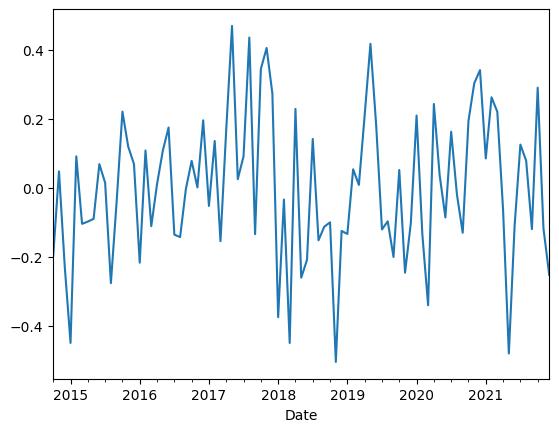

In [180]:
residuals = res1.resid
residuals.plot()

<Axes: ylabel='Density'>

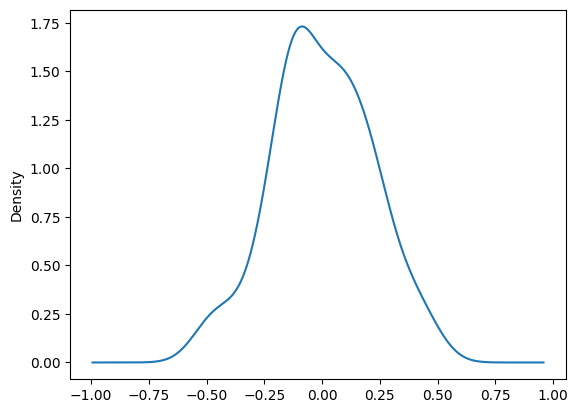

In [181]:
# density plot of residuals
residuals.plot(kind='kde')

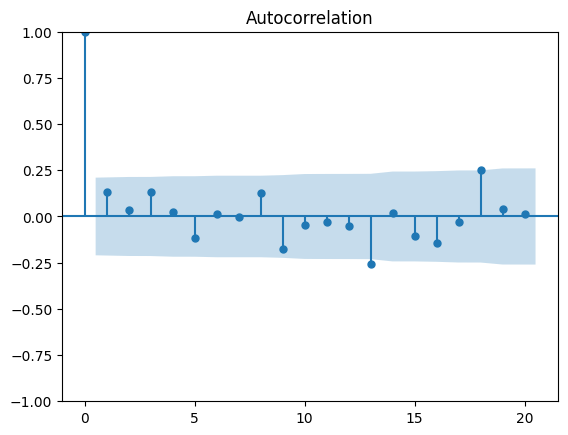

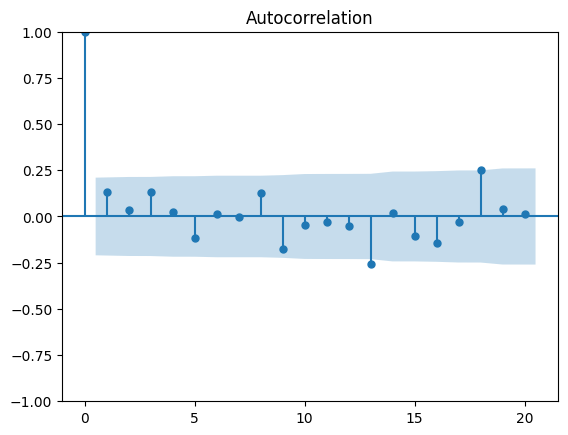

In [182]:
plot_acf(residuals)

In [183]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.973365e+00
p-value                 2.743345e-12
# lags used             0.000000e+00
# observations          8.600000e+01
critical value (1%)    -3.508783e+00
critical value (5%)    -2.895784e+00
critical value (10%)   -2.585038e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [184]:
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar_predictions = np.exp(res1.predict(start=start, end=end, dynamic=False).rename(f'AR({p}) Predictions'))

In [185]:
ar_predictions

,AR(1) Predictions
2022-01-31,48464.073319
2022-02-28,50713.958735
2022-03-31,53059.664256
2022-04-30,55504.873860
2022-05-31,58053.396296
2022-06-30,60709.168658
2022-07-31,63476.260034
2022-08-31,66358.875237
2022-09-30,69361.358614
2022-10-31,72488.197941


<Axes: xlabel='Date'>

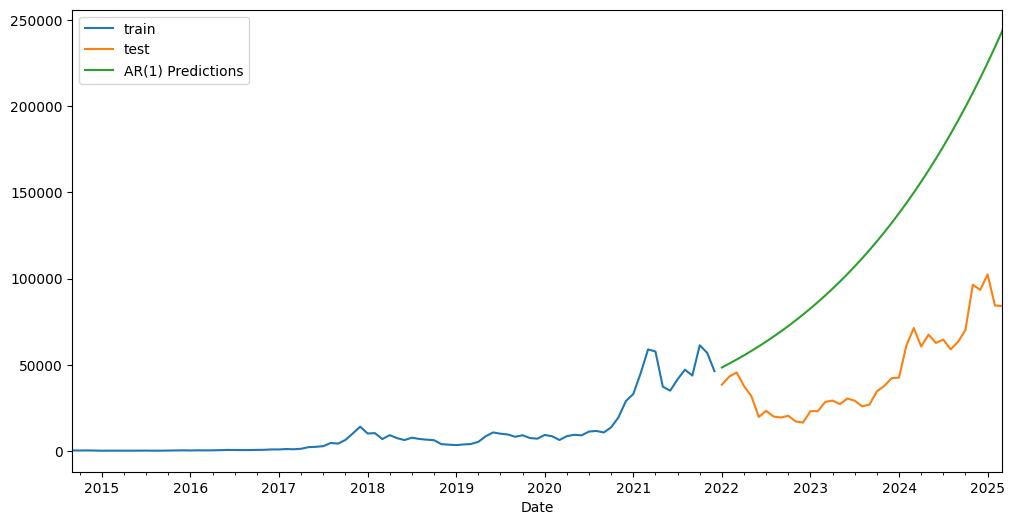

In [186]:
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar_predictions.plot(legend=True,figsize=(12,6))

In [187]:
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")

metrics( test, ar_predictions)


MSE: 7519342580.321599
RMSE: 86714.14290830302
MAE: 78074.65133725778
R²: -11.818535970677097
MAPE: 194.0232658775538
SMAPE: 92.5435623057837


# Modelo Arima

In [188]:
arima_model = ARIMA(train_log, order=(p,d,q))
fitted_arima_model = arima_model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(1, 0, 0)   Log Likelihood                   6.380
Date:                Thu, 27 Mar 2025   AIC                             -6.761
Time:                        23:38:54   BIC                              0.671
Sample:                    09-30-2014   HQIC                            -3.767
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3120      1.941      4.283      0.000       4.508      12.116
ar.L1          0.9951      0.015     64.321      0.000       0.965       1.025
sigma2         0.0481      0.008      6.072      0.0

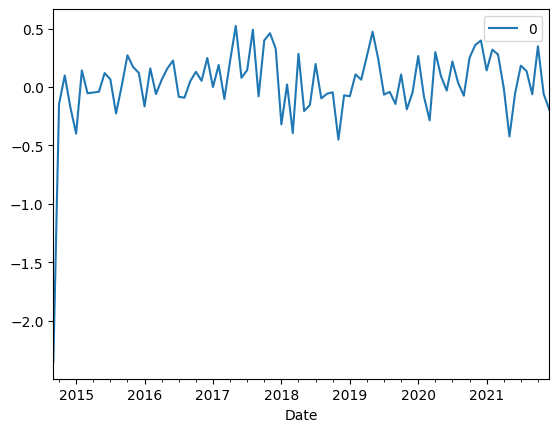

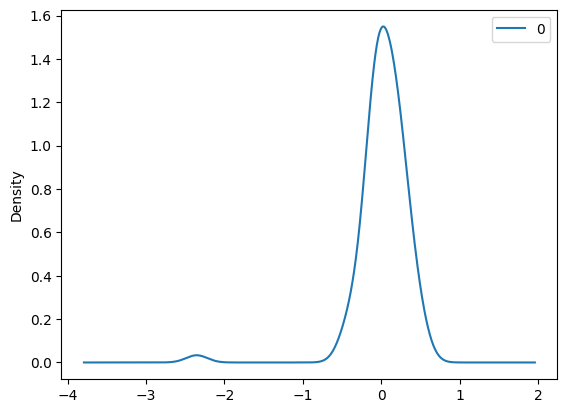

In [189]:

# summary of fit model
print(fitted_arima_model.summary())
# line plot of residuals
residuals = DataFrame(fitted_arima_model.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

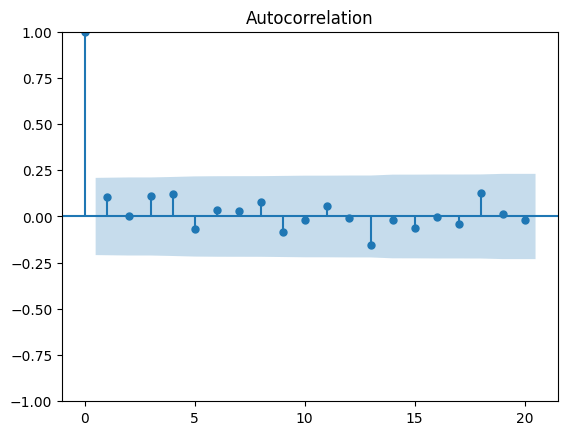

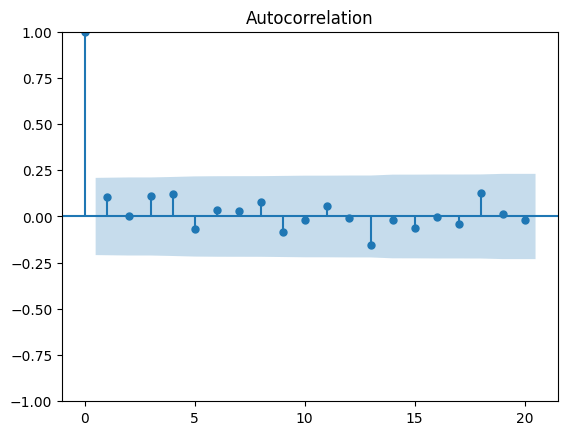

In [190]:
plot_acf(residuals)

In [191]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.309120e+01
p-value                 1.787052e-24
# lags used             0.000000e+00
# observations          8.700000e+01
critical value (1%)    -3.507853e+00
critical value (5%)    -2.895382e+00
critical value (10%)   -2.584824e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [192]:
history = train_log['y'].tolist()

arima_predictions = np.array([])
#walk-foward validation

for t in range(h):
  arima_model = ARIMA(history, order=(p,d,q))
  # fit model
  fitted_arima_model = arima_model.fit()
  yhat = np.exp(fitted_arima_model.forecast()[0])
  arima_predictions = np.append(arima_predictions, yhat)
  obs = test['y'].iloc[t]
  history.append(np.log(obs))
  print(f'predicted={yhat}, expected={obs}')



predicted=45756.45052793742, expected=38483.125
predicted=38016.391668150005, expected=43193.234375
predicted=42684.00848650349, expected=45538.67578125
predicted=45013.662942730254, expected=37714.875
predicted=37271.43422659017, expected=31792.310546875
predicted=31414.28857914705, expected=19784.7265625
predicted=19535.2238519749, expected=23336.896484375
predicted=23044.72238772004, expected=20049.763671875
predicted=19800.800542445595, expected=19431.7890625
predicted=19193.69237865383, expected=20495.7734375
predicted=20247.22468313578, expected=17168.56640625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=16963.23315397053, expected=16547.49609375
predicted=16352.409837578616, expected=23139.283203125
predicted=22859.26830214781, expected=23147.353515625
predicted=22870.69930525533, expected=28478.484375
predicted=28140.337603885855, expected=29268.806640625
predicted=28925.956758838794, expected=27219.658203125
predicted=26903.68520051081, expected=30477.251953125
predicted=30128.101359164433, expected=29230.111328125
predicted=28898.6896081954, expected=25931.47265625
predicted=25639.420643381054, expected=26967.916015625
predicted=26667.730599829334, expected=34667.78125
predicted=34284.31668490685, expected=37712.74609375
predicted=37301.96940345771, expected=42265.1875
predicted=41813.19614053934, expected=42582.60546875
predicted=42132.868820001655, expected=61198.3828125
predicted=60564.90748352619, expected=71333.6484375
predicted=70614.84506636224, expected=60636.85546875
predicted=60017.05448768194, expected=67491.4140625
predicted=66816.74202061065, expected=62678.2

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='ds'>

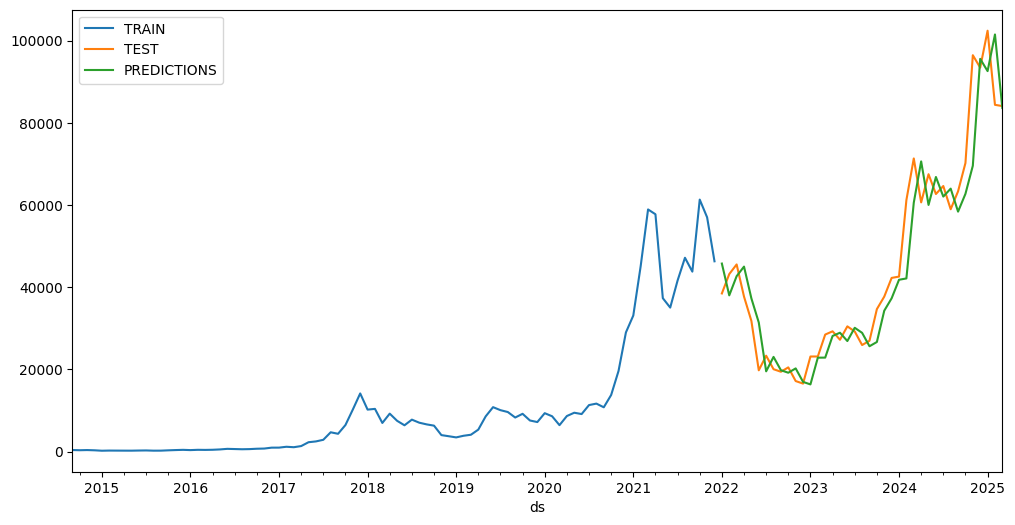

In [193]:
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':arima_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


In [194]:
metrics(test, arima_predictions)

MSE: 62319793.91490879
RMSE: 7894.28868961028
MAE: 5667.0241314900295
R²: 0.8937608558926337
MAPE: 12.863447533976228
SMAPE: 12.95048390851799


In [195]:
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  18.383
Date:                Thu, 27 Mar 2025   AIC                            -30.766
Time:                        23:39:06   BIC                            -22.257
Sample:                             0   HQIC                           -27.309
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6909      2.144      4.054      0.000       4.489      12.892
ar.L1          0.9965      0.011     88.496      0.000       0.974       1.019
sigma2         0.0420      0.005      7.764      0.000       0.031       0.053
===================================================================================
Ljung-Box (L1) (Q):                   2.08   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.15   Prob(JB):                         0.98
Heteroskedasticity (H):               0.64   Skew:                            -0.04
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelo Exponential Smoothing

/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='ds'>

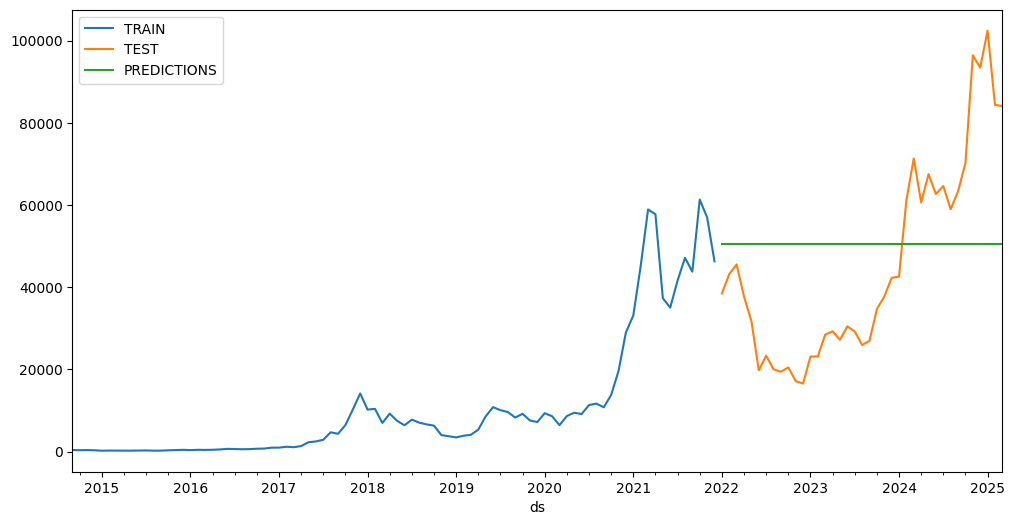

In [196]:
# Simple Exponential Smoothing (SES) for data without trends or seasonality
ses_model = SimpleExpSmoothing(train)
fitted_ses_model = ses_model.fit(smoothing_level=0.5)
ses_predictions = fitted_ses_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':ses_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Holt

<Axes: xlabel='ds'>

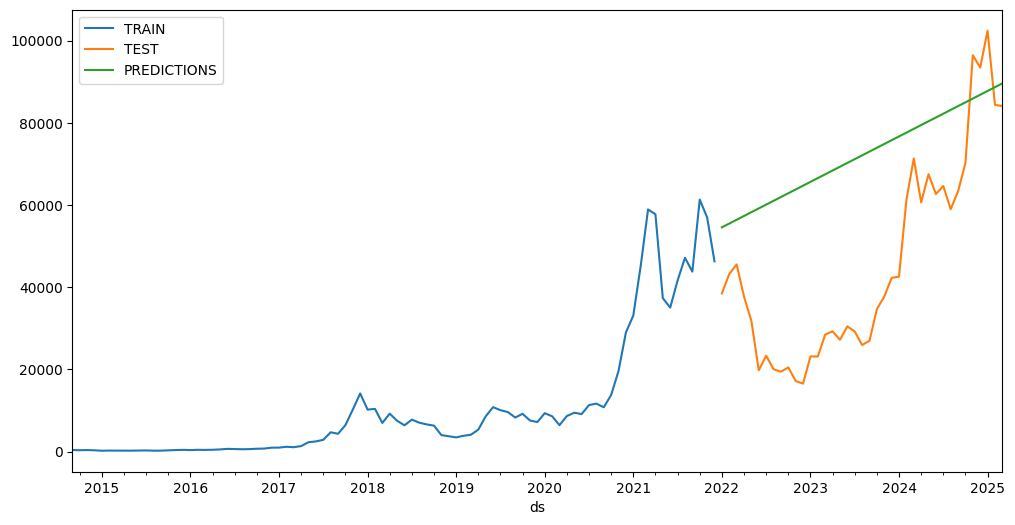

In [197]:
# Double exponential smoothing, also known as Holt's method, extends single exponential smoothing to capture trends in the data.

holt_model = ExponentialSmoothing(train, trend="add", seasonal=None)
fitted_holt_model = holt_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
holt_predictions = fitted_holt_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':holt_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Damped

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='ds'>

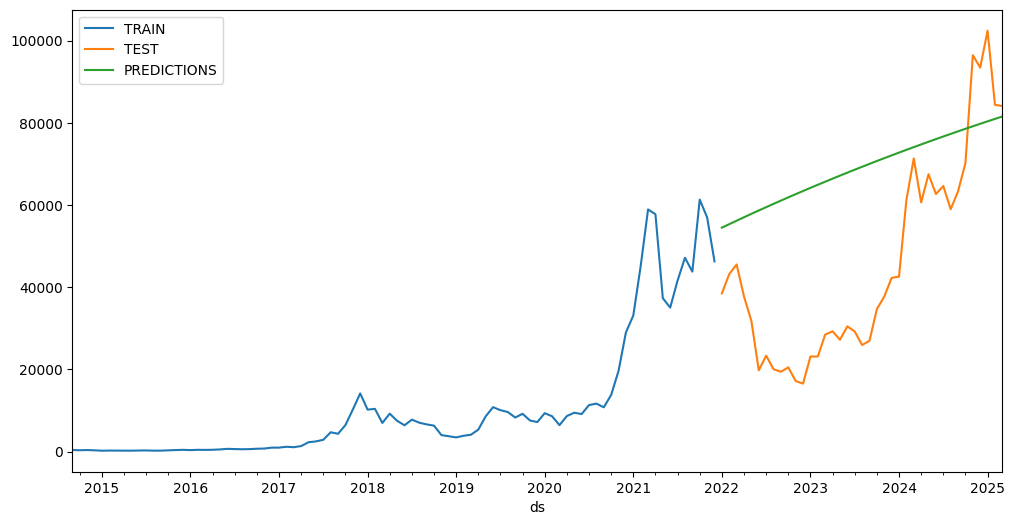

In [198]:
# The Damped Trend model is an extension of Holt’s linear method that introduces a damping parameter (ϕ),
# which gradually reduces the influence of the trend component over time

damped_model = ExponentialSmoothing(train, trend="add", seasonal=None, damped_trend=True)
fitted_damped_model = damped_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
damped_predictions = fitted_damped_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':damped_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
